In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load the labels and similarity matrix
with open('labels.txt', 'r') as file:
    labels = file.read().splitlines()

In [4]:
sim_mat = np.loadtxt('sim_mat.txt')

In [5]:
# Map filenames to numerical labels
label_dict = {}
for i, label in enumerate(labels):
    subject_id = label.split('_')[0]
    if subject_id not in label_dict:
        label_dict[subject_id] = len(label_dict)
    labels[i] = label_dict[subject_id]

In [6]:
labels = np.array(labels)

In [7]:
# Extract genuine and impostor scores
genuine_scores = []
impostor_scores = []

num_subjects = len(labels)
for i in range(num_subjects):
    for j in range(num_subjects):
        if i != j:
            if labels[i] == labels[j]:
                genuine_scores.append(sim_mat[i, j])
            else:
                impostor_scores.append(sim_mat[i, j])

In [8]:
# Convert lists to numpy arrays for easier manipulation
genuine_scores = np.array(genuine_scores)
impostor_scores = np.array(impostor_scores)

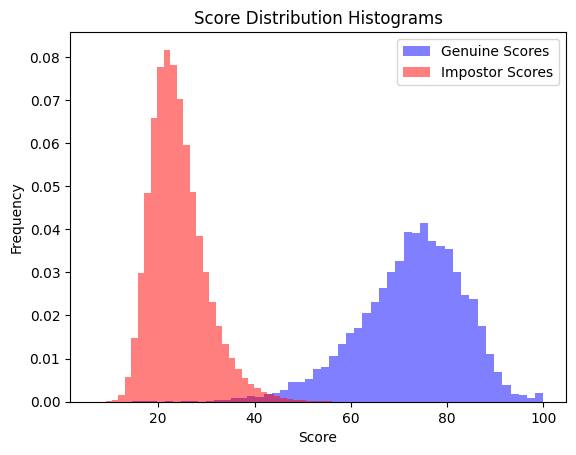

In [9]:
# Plot the score distribution histograms
plt.hist(genuine_scores, bins=50, alpha=0.5, label='Genuine Scores', color='blue', density=True)
plt.hist(impostor_scores, bins=50, alpha=0.5, label='Impostor Scores', color='red', density=True)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Score Distribution Histograms')
plt.show()

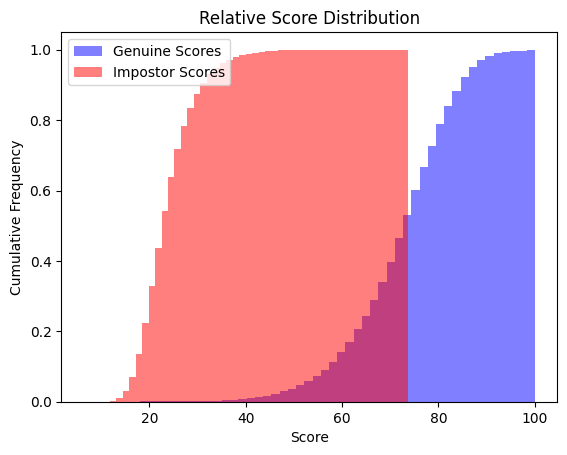

In [10]:
# Plot the relative score distribution
plt.hist(genuine_scores, bins=50, alpha=0.5, label='Genuine Scores', color='blue', density=True, cumulative=True)
plt.hist(impostor_scores, bins=50, alpha=0.5, label='Impostor Scores', color='red', density=True, cumulative=True)
plt.xlabel('Score')
plt.ylabel('Cumulative Frequency')
plt.legend(loc='upper left')
plt.title('Relative Score Distribution')
plt.show()

###  2.  D-prime Calculation:  Compute the d-prime (d') value to assess the separation between genuine and impostor score distributions.


In [11]:
# Calculate means
mu_genuine = np.mean(genuine_scores)
mu_impostor = np.mean(impostor_scores)

In [12]:
# Calculate standard deviations
sigma_genuine = np.std(genuine_scores)
sigma_impostor = np.std(impostor_scores)

In [13]:
# Calculate d-prime
d_prime = (mu_genuine - mu_impostor) / np.sqrt(0.5 * (sigma_genuine**2 + sigma_impostor**2))

In [14]:
print(f"d-prime (d') value: {d_prime}")

d-prime (d') value: 5.540634353017718


###  3. Receiver Operating Characteristic (ROC) Curve:
 a. Calculate the True Positive Rate (TPR) and False Positive Rate (FPR) for varying thresholds. (a minimum of 10 thresholds.)
 b. Plot the ROC curve and compute the Area Under the Curve (AUC).

In [15]:
from sklearn.metrics import roc_curve, auc

In [16]:
# Combine genuine and impostor scores
scores = np.concatenate([genuine_scores, impostor_scores])
labels = np.concatenate([np.ones(len(genuine_scores)), np.zeros(len(impostor_scores))])

In [17]:
# Calculate TPR and FPR for varying thresholds
fpr, tpr, thresholds = roc_curve(labels, scores)

In [18]:
# Compute the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

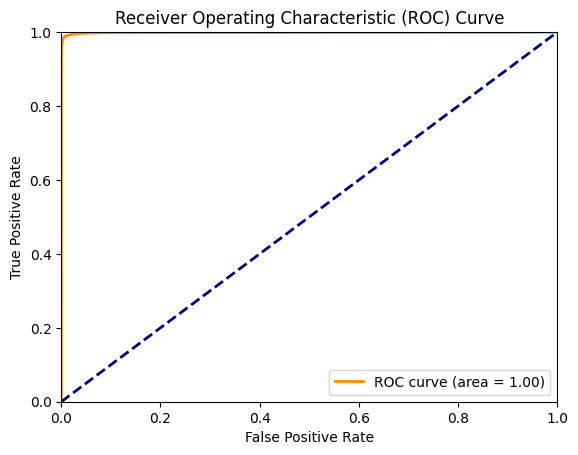

In [19]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### 4.  Cumulative Match Characteristic (CMC) Curve:  Generate a CMC curve to evaluate the rank-based identification performance of the biometric system.


In [20]:
# Initialize CMC curve
cmc_curve = np.zeros(num_subjects)

In [21]:
# Calculate CMC curve
for i in range(num_subjects):
    # Get the similarity scores for the i-th probe
    scores = sim_mat[i, :]
    
    # Get the sorted indices of the scores
    sorted_indices = np.argsort(scores)[::-1]
    
    # Get the ranks of the correct matches
    correct_match_ranks = np.where(labels[sorted_indices] == labels[i])[0]
    
    # Update the CMC curve
    for rank in correct_match_ranks:
        cmc_curve[rank:] += 1

In [22]:
# Normalize the CMC curve
cmc_curve = cmc_curve / num_subjects

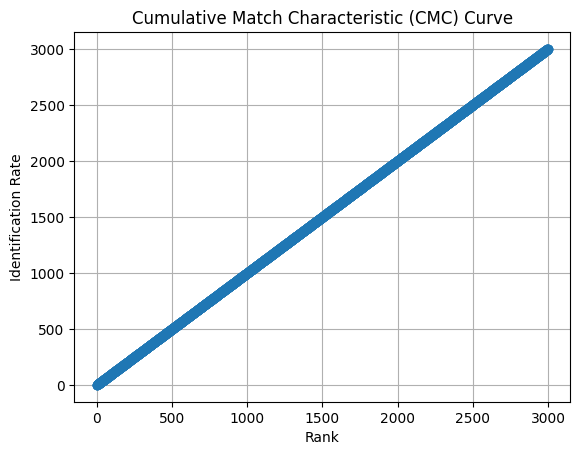

In [23]:
# Plot the CMC curve
plt.plot(cmc_curve, marker='o')
plt.xlabel('Rank')
plt.ylabel('Identification Rate')
plt.title('Cumulative Match Characteristic (CMC) Curve')
plt.grid(True)
plt.show()

##  5. False Match Rate (FMR) and False Non-Match Rate (FNMR) Curves:
 a. Plot the FMR and FNMR curves on the same graph relative to the threshold.
 b. Identify and mark the operating threshold that minimizes the difference between FMR and FNMR

In [24]:
# Combine genuine and impostor scores
scores = np.concatenate([genuine_scores, impostor_scores])
labels = np.concatenate([np.ones(len(genuine_scores)), np.zeros(len(impostor_scores))])

In [25]:
# Define thresholds
thresholds = np.linspace(min(scores), max(scores), 100)

In [26]:
# Initialize lists to store FMR and FNMR values
fmr = []
fnmr = []

In [27]:
# Calculate FMR and FNMR for each threshold
for threshold in thresholds:
    fmr.append(np.sum(impostor_scores >= threshold) / len(impostor_scores))
    fnmr.append(np.sum(genuine_scores < threshold) / len(genuine_scores))

In [28]:
# Convert lists to numpy arrays for easier manipulation
fmr = np.array(fmr)
fnmr = np.array(fnmr)

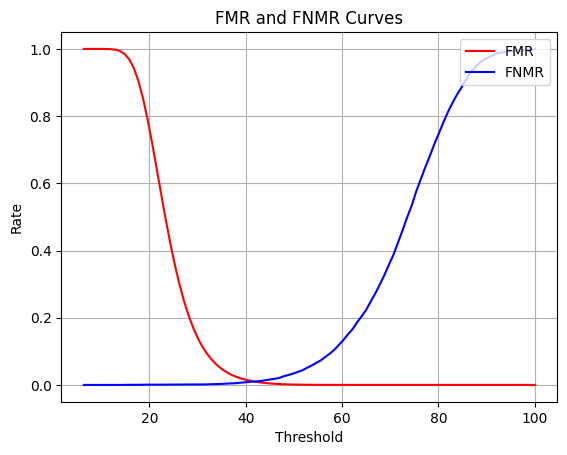

In [29]:
# Plot FMR and FNMR curves
plt.plot(thresholds, fmr, label='FMR', color='red')
plt.plot(thresholds, fnmr, label='FNMR', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('FMR and FNMR Curves')
plt.legend(loc='upper right')
plt.grid(True)

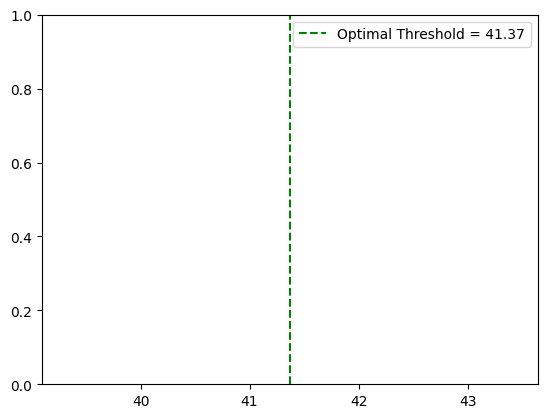

In [30]:
# Identify and mark the operating threshold that minimizes the difference between FMR and FNMR
min_diff_index = np.argmin(np.abs(fmr - fnmr))
optimal_threshold = thresholds[min_diff_index]
plt.axvline(x=optimal_threshold, color='green', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.legend(loc='upper right')
plt.show()

In [31]:
print(f'Optimal Threshold: {optimal_threshold:.2f}')
print(f'FMR at Optimal Threshold: {fmr[min_diff_index]:.4f}')
print(f'FNMR at Optimal Threshold: {fnmr[min_diff_index]:.4f}')

Optimal Threshold: 41.37
FMR at Optimal Threshold: 0.0110
FNMR at Optimal Threshold: 0.0099
